In [2]:
import numpy as np
import scipy.ndimage.filters as filters


def del2(M):
    dx = 1
    dy = 1
    rows, cols = M.shape
    dx = dx * np.ones((1, cols - 1))
    dy = dy * np.ones((rows - 1, 1))

    mr, mc = M.shape
    D = np.zeros((mr, mc))

    if (mr >= 3):
        ## x direction
        ## left and right boundary
        D[:, 0] = (M[:, 0] - 2 * M[:, 1] + M[:, 2]) / (dx[:, 0] * dx[:, 1])
        D[:, mc - 1] = (M[:, mc - 3] - 2 * M[:, mc - 2] + M[:, mc - 1]) \
                       / (dx[:, mc - 3] * dx[:, mc - 2])

        ## interior points
        tmp1 = D[:, 1:mc - 1]
        tmp2 = (M[:, 2:mc] - 2 * M[:, 1:mc - 1] + M[:, 0:mc - 2])
        tmp3 = np.kron(dx[:, 0:mc - 2] * dx[:, 1:mc - 1], np.ones((mr, 1)))
        D[:, 1:mc - 1] = tmp1 + tmp2 / tmp3

    if (mr >= 3):
        ## y direction
        ## top and bottom boundary
        D[0, :] = D[0, :] + \
                  (M[0, :] - 2 * M[1, :] + M[2, :]) / (dy[0, :] * dy[1, :])

        D[mr - 1, :] = D[mr - 1, :] \
                       + (M[mr - 3, :] - 2 * M[mr - 2, :] + M[mr - 1, :]) \
                         / (dy[mr - 3, :] * dx[:, mr - 2])

        ## interior points
        tmp1 = D[1:mr - 1, :]
        tmp2 = (M[2:mr, :] - 2 * M[1:mr - 1, :] + M[0:mr - 2, :])
        tmp3 = np.kron(dy[0:mr - 2, :] * dy[1:mr - 1, :], np.ones((1, mc)))
        D[1:mr - 1, :] = tmp1 + tmp2 / tmp3

    return D / 4


def drlse_edge(phi_0, g, lmda, mu, alfa, epsilon, timestep, iters, potentialFunction):  # Updated Level Set Function
    """

    :param phi_0: level set function to be updated by level set evolution
    :param g: edge indicator function
    :param lmda: weight of the weighted length term
    :param mu: weight of distance regularization term
    :param alfa: weight of the weighted area term
    :param epsilon: width of Dirac Delta function
    :param timestep: time step
    :param iters: number of iterations
    :param potentialFunction: choice of potential function in distance regularization term.
%              As mentioned in the above paper, two choices are provided: potentialFunction='single-well' or
%              potentialFunction='double-well', which correspond to the potential functions p1 (single-well)
%              and p2 (double-well), respectively.
    """
    phi = phi_0.copy()
    [vy, vx] = np.gradient(g)
    for k in range(iters):
        phi = NeumannBoundCond(phi)
        [phi_y, phi_x] = np.gradient(phi)
        s = np.sqrt(np.square(phi_x) + np.square(phi_y))
        smallNumber = 1e-10
        Nx = phi_x / (s + smallNumber)  # add a small positive number to avoid division by zero
        Ny = phi_y / (s + smallNumber)
        curvature = div(Nx, Ny)
        if potentialFunction == 'single-well':
            distRegTerm = filters.laplace(phi, mode='wrap') - curvature  # compute distance regularization term in equation (13) with the single-well potential p1.
        elif potentialFunction == 'double-well':
            distRegTerm = distReg_p2(phi)  # compute the distance regularization term in eqaution (13) with the double-well potential p2.
        else:
            print('Error: Wrong choice of potential function. Please input the string "single-well" or "double-well" in the drlse_edge function.')
        diracPhi = Dirac(phi, epsilon)
        areaTerm = diracPhi * g  # balloon/pressure force
        edgeTerm = diracPhi * (vx * Nx + vy * Ny) + diracPhi * g * curvature
        phi = phi + timestep * (mu * distRegTerm + lmda * edgeTerm + alfa * areaTerm)
    return phi


def distReg_p2(phi):
    """
        compute the distance regularization term with the double-well potential p2 in equation (16)
    """
    [phi_y, phi_x] = np.gradient(phi)
    s = np.sqrt(np.square(phi_x) + np.square(phi_y))
    a = (s >= 0) & (s <= 1)
    b = (s > 1)
    ps = a * np.sin(2 * np.pi * s) / (2 * np.pi) + b * (s - 1)  # compute first order derivative of the double-well potential p2 in equation (16)
    dps = ((ps != 0) * ps + (ps == 0)) / ((s != 0) * s + (s == 0))  # compute d_p(s)=p'(s)/s in equation (10). As s-->0, we have d_p(s)-->1 according to equation (18)
    return div(dps * phi_x - phi_x, dps * phi_y - phi_y) + filters.laplace(phi, mode='wrap')


def div(nx, ny):
    [junk, nxx] = np.gradient(nx)
    [nyy, junk] = np.gradient(ny)
    return nxx + nyy


def Dirac(x, sigma):
    f = (1 / 2 / sigma) * (1 + np.cos(np.pi * x / sigma))
    b = (x <= sigma) & (x >= -sigma)
    return f * b


def NeumannBoundCond(f):
    """
        Make a function satisfy Neumann boundary condition
    """
    [ny, nx] = f.shape
    g = f.copy()

    g[0, 0] = g[2, 2]
    g[0, nx-1] = g[2, nx-3]
    g[ny-1, 0] = g[ny-3, 2]
    g[ny-1, nx-1] = g[ny-3, nx-3]

    g[0, 1:-1] = g[2, 1:-1]
    g[ny-1, 1:-1] = g[ny-3, 1:-1]

    g[1:-1, 0] = g[1:-1, 2]
    g[1:-1, nx-1] = g[1:-1, nx-3]

    return g

print('Done')

Done


In [9]:
# from scipy.misc import imread
import imageio
# import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage.filters as filters
from skimage import measure
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

(65, 83)
show fig 2 first time


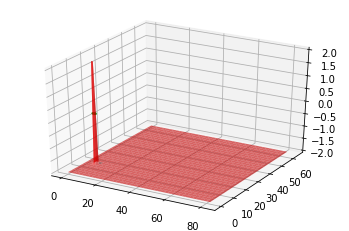

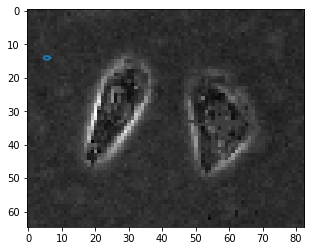

In [73]:
# img = np.array(imread('gourd.bmp', True), dtype='float32')
img = imageio.imread('../twocells.bmp')
img = img[:,:,1]
# im_t = img[:, :, 1]

# parameters
timestep = 1        # time step
mu = 0.2/timestep   # coefficient of the distance regularization term R(phi)
iter_inner = 4
iter_outer = 25
lmda = 2            # coefficient of the weighted length term L(phi)
alfa = -9           # coefficient of the weighted area term A(phi)
epsilon = 2.0       # parameter that specifies the width of the DiracDelta function

sigma = 0.8         # scale parameter in Gaussian kernel
img_smooth = filters.gaussian_filter(img, sigma)    # smooth image by Gaussian convolution
[Iy, Ix] = np.gradient(img_smooth)
f = np.square(Ix) + np.square(Iy)
g = 1 / (1+f)    # edge indicator function.

# initialize LSF as binary step function
c0 = 2
initialLSF = c0 * np.ones(img.shape)
# generate the initial region R0 as two rectangles
# initialLSF[24:35, 19:25] = -c0
print(initialLSF.shape)
initialLSF[14:15, 5:7] = -c0
phi = initialLSF.copy()

plt.ion()
# fig1 = plt.figure(1)

def show_fig1():
#     clear_output(wait=True)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, projection='3d')
    y, x = phi.shape
    x = np.arange(0, x, 1)
    y = np.arange(0, y, 1)
    X, Y = np.meshgrid(x, y)
    ax1.plot_surface(X, Y, -phi, rstride=2, cstride=2, color='r', linewidth=0, alpha=0.6, antialiased=True)
    ax1.contour(X, Y, phi, 0, colors='g', linewidths=2)
    del fig1

show_fig1()
# clear_output(wait=True)
# fig2 = plt.figure(2)


def show_fig2():
#     clear_output(wait=True)
    fig2 = plt.figure()
    contours = measure.find_contours(phi, 0)
    ax2 = fig2.add_subplot(111)
    ax2.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
    for n, contour in enumerate(contours):
        ax2.plot(contour[:, 1], contour[:, 0], linewidth=2) 
    del fig2

show_fig2()
print('show fig 2 first time')


show fig 2 for 0 time
show fig 2 for 50 time
show fig 2 for 100 time
show fig 2 for 150 time


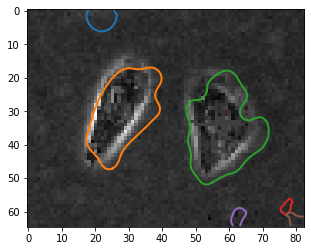

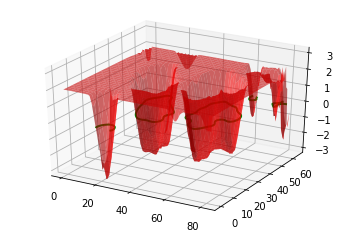

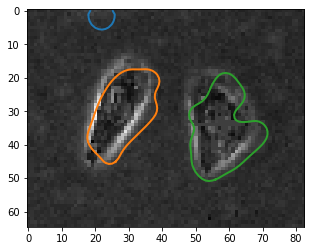

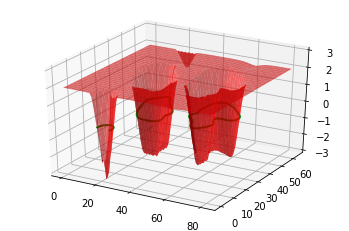

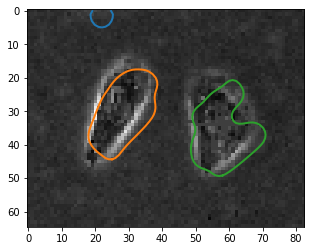

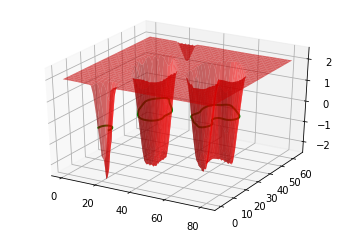

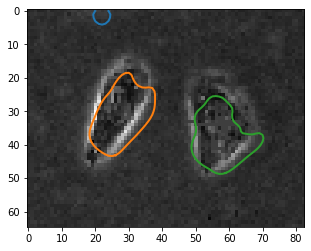

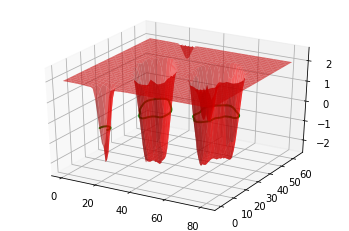

In [75]:
potential = 2
if potential == 1:
    potentialFunction = 'single-well'  # use single well potential p1(s)=0.5*(s-1)^2, which is good for region-based model
elif potential == 2:
    potentialFunction = 'double-well'  # use double-well potential in Eq. (16), which is good for both edge and region based models
else:
    potentialFunction = 'double-well'  # default choice of potential function

# start level set evolution
# for n in range(iter_outer):
for n in range(200):
    phi = drlse_edge(phi, g, lmda, mu, alfa, epsilon, timestep, iter_inner, potentialFunction)
    if np.mod(n, 50) == 0:
#         clear_output(wait=True)
        print('show fig 2 for %i time' % n)
#         fig2.clf()
        show_fig2()
#         fig2.show()
#         fig1.clf()
        show_fig1()
#         fig1.show()
#         plt.pause(0.1)

show final fig 2


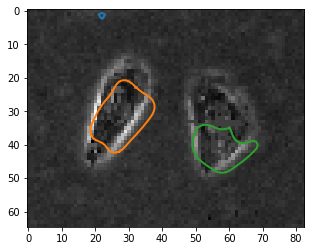

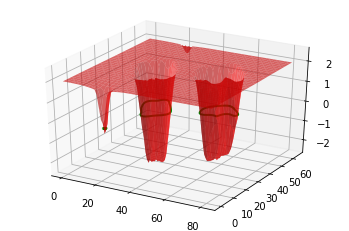

In [76]:
# refine the zero level contour by further level set evolution with alfa=0
alfa = 0
iter_refine = 10
phi = drlse_edge(phi, g, lmda, mu, alfa, epsilon, timestep, iter_refine, potentialFunction)

finalLSF = phi.copy()
print('show final fig 2')
# fig2.clf()
show_fig2()
# fig1.clf()
show_fig1()


'''
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111, projection='3d')
y, x = finalLSF.shape
x = np.arange(0, x, 1)
y = np.arange(0, y, 1)
X, Y = np.meshgrid(x, y)
ax3.plot_surface(X, Y, -finalLSF, rstride=2, cstride=2, color='r', linewidth=0, alpha=0.6, antialiased=True)
ax3.contour(X, Y, finalLSF, 0, colors='g', linewidths=2)
'''

# plt.pause(10)
plt.show()

In [33]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=2)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

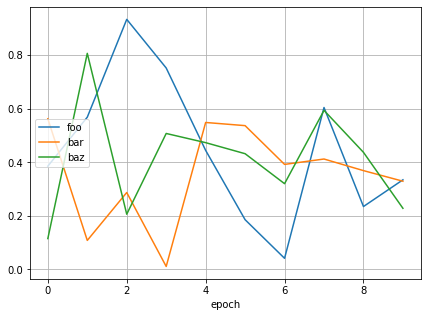

In [34]:
data = collections.defaultdict(list)
for i in range(10):
    data['foo'].append(np.random.random())
    data['bar'].append(np.random.random())
    data['baz'].append(np.random.random())
    live_plot(data)